In [22]:
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
import math
import cmath
import scipy
import scipy.interpolate as interpolate
import scipy.integrate as integrate
import scipy.special as special
import numpy.ma as ma
#np.set_printoptions(threshold=sys.maxsize)
pts = 5000 # number of iterator steps where neccessary
H_to_K = 1/0.000003166808534191 # conversion of Henries to Kelvin
tol = 1e-6 # tolerance where neccessary

In [24]:
r = np.linspace(4,60, pts) # range of r values to iterate over, 4 -> 60 Bohr radii
dr = r[1] - r[0] # spacing dr
C12 = 3.05e8 # C12 coefficient in Eh*ao
C6 = 4710 # C6 coefficient in Eh*ao
Vr = (C12/(r**12)) - (C6/(r**6)) # standard Lennard-Jones interatomic potential
Eo = 3.166808534191e-12 # inital particle energy, 1uK in Hartrees
me = 9.1093837e-28 # electron mass in grams
mrb_g = 1.4192261e-22 # rubidium mass in grams
mrb = mrb_g/me # rubidium mass in au
mu = (mrb**2)/(2*mrb) # reduced mass of rubidium
hbar = 1.0546e-27 # reduced Planck constant in cgs
e = 4.8032e-10 # electron charge in cgs
ao = (hbar**2)/(me*e**2) # Bohr radius in cgs

# Generic DVR for finding bound states (E < 0)
### for a coordinate x in a 'box' from a to b, we can use r from r1 to r2, where r1 is small enough to see the wave function diminish to zero and r2 large enough to get all the bound states

## $ x \in (a,b) $, $x_{i} = a + \frac{(b-a)i}{N}, i = 1,2,..,N-1$, $dx = \frac{(b-a)}{N}$

## $ T_{ij} = \frac{1}{2} \frac{(-1)^{i-j}}{(b-a)^2} \frac{\pi^2}{2} [\frac{1}{sin^2(\frac{\pi (i-j)}{2N})} - \frac{1}{sin^2(\frac{\pi (i+j)}{2N})}] $
## $ T_{ii} = \frac{1}{(b-a)^2} \frac{\pi^2}{4} [\frac{2N^2 + 1}{3} - \frac{1}{sin^2(\frac{\pi i}{N})}]$
## $ V_{ii} = V(x_i) $
## $ H_{ii} = T_{ii} + V_{ii}$
## $ H_{ij} = T_{ij}$

## $H_{ii} = \frac{1}{(b-a)^2} \frac{\pi^2}{4 \mu} [\frac{2N^2 + 1}{3} - \frac{1}{sin^2(\frac{\pi i}{N})}] + \frac{C_{12}}{r_{i}^{12}} - \frac{C_{6}}{r_{i}^6} $
## $ H_{ij} = \frac{(-1)^{i-j}}{(b-a)^2} \frac{\pi^2}{4\mu} [\frac{1}{sin^2(\frac{\pi (i-j)}{2N})} - \frac{1}{sin^2(\frac{\pi (i+j)}{2N})}] $

In [37]:
def Hamiltonian_DVR(a, b, dx): # DVR method for finding bound states
    N = int((b-a)/dx) # Number of grid points
    ipaper = np.arange(1,N, 1.0) # indexing from the paper, given i = 1,2,...,N-1
    x = a + dx*ipaper # grid from paper
    Vx = C12/(x**12) - C6/(x**6) # Lennard-Jones potential
    Vx = np.insert(Vx,0,0) # Insert a 0 at the 0th index of list to account for mismatched indexing

    #print(f' ipaper = {ipaper}')
    #print(f' x = {x}')
    print(f' N - 1 = {N-1}')
    #print(f' len(x) = {len(x)}')
    #print(x[-1]/(b-dx))
    #print(x[0]/(a+dx))
    #print(f' dx = {dx}')
    #print(f'dx from grid  = {x[1] - x[0]}')
    #print(Vx[len(Vx) - 1]/(0.5*(b - dx - d)**2))

    H_DVR = np.zeros((len(x), len(x))) # Initialize empty Hamiltonian matrix of size N-1 x N-1
    Vmat = np.zeros((len(x) + 10, len(x) + 10))
    Tmat = np.zeros((len(x) + 10, len(x) + 10))


    for i in ipaper:
        for j in ipaper:
            if int(i) == int(j): # fill in diagonal components of the Hamiltonian
                prefactorii = (np.pi**2)/(4*mu*(b-a)**2)
                bracketii = ((2*N**2 + 1)/3) - (1/((np.sin(np.pi*(i/N)))**2))
                
                Tmat[int(i)][int(j)] = prefactorii*bracketii
                Vmat[int(i)][int(j)] = Vx[int(j)]
                
                H_DVR[int(i) - 1][int(j) - 1] = Tmat[int(i)][int(j)] + Vmat[int(i)][int(j)]
            
            if i != j: # fill in off-diagonal components of the Hamiltonian
                diff = i - j
                prefactorij = ((-1)**(diff))*(np.pi**2)/(4*mu*(b-a)**2)
                bracketij = (1/((np.sin(np.pi*((diff)/(2*N))))**2)) - (1/((np.sin(np.pi*((i+j)/(2*N))))**2))
                Tmat[int(i)][int(j)] = prefactorij*bracketij               
                
                H_DVR[int(i) - 1][int(j) - 1] = Tmat[int(i)][int(j)]
                
    #assert(np.allclose(H_DVR, np.transpose(H_DVR)))
    #print(f' H = {H}')
    return H_DVR

In [ ]:
a1 = 4.5
b1 = 100
dx1 = 0.01

N1 = int((b1-a1)/dx1) # Number of grid points
ipap = np.arange(1,N1, 1.0) # indexing from the paper, given i = 1,2,...,N-1
x1 = a1 + dx1*ipap


VLJ = C12/(x1**12) - C6/(x1**6)
Vmin = min(VLJ)

H = Hamiltonian_DVR(a1, b1, dx1)

In [ ]:
Heig = np.linalg.eigh(H)[0]
print(f'there are {len(Heig[Heig<0])} bound states')

Eigvec = np.linalg.eigh(H)[1]
Hvec = []
for i in range(len(H[0])):
    avec = Eigvec[:,i]
    Hvec.append(avec)
for i in range(len(Hvec)):
    INT = np.trapz(np.abs(Hvec[i])**2,x1)
    A = 1/np.sqrt(INT)
    Hvec[i] = A*Hvec[i]

# Fast Hamiltonian DVR

In [ ]:
Tmat = np.zeros((len(xp), len(xp))) # Initialize empty T matrix of size N-1 x N-1
KEmat = np.zeros((len(xp) + 10, len(xp) + 10))

for i in ipaperp:
    for j in ipaperp:
        if int(i) == int(j): # fill in diagonal components of the T matrix
            prefactorii = (np.pi**2)/(4*mu*(r2-r1)**2)
            bracketii = ((2*Np**2 + 1)/3) - (1/((np.sin(np.pi*(i/Np)))**2))
                
            KEmat[int(i)][int(j)] = prefactorii*bracketii
            Tmat[int(i) - 1][int(j) - 1] = KEmat[int(i)][int(j)]
            
        if i != j: # fill in off-diagonal components of the T matrix
            diff = i - j
            prefactorij = ((-1)**(diff))*(np.pi**2)/(4*mu*(r2-r1)**2)
            bracketij = (1/((np.sin(np.pi*((diff)/(2*Np))))**2)) - (1/((np.sin(np.pi*((i+j)/(2*Np))))**2))
                
            KEmat[int(i)][int(j)] = prefactorij*bracketij               
            Tmat[int(i) - 1][int(j) - 1] = KEmat[int(i)][int(j)]

In [ ]:
def Hamiltonian_DVR(a, b, dx, C6_coef, KE_matrix): # DVR method for finding bound states
    N = int((b-a)/dx) # Number of grid points
    ipaper = np.arange(1,N, 1.0) # indexing from the paper, given i = 1,2,...,N-1
    x = a + dx*ipaper # grid from paper
    
    for i in range(100):
        rand1 = np.random.rand()
        rand2 = np.random.rand()
        rand3 = np.random.rand()

        Theta_A = np.arccos(1 - 2*rand1)
        Theta_B = np.arccos(1 - 2*rand2)
        PHI = 2*np.pi*rand3
        C_3_coef = ((d_NaK)**2)*(np.sin(Theta_A)*np.sin(Theta_B)*np.cos(PHI) - 2*np.cos(Theta_A)*np.cos(Theta_B))
        if C_3_coef > 0:
            #print(i)
            break
    #C6_rand = np.random.randint(int(5e4), int(9.9e4))
    V_dip_dip = (C_3_coef)/(x**3)
    
    #Vx = C6_rand/(x**6) - V_dip_dip # Excited potential
    Vx = C6_coef/(x**6) - V_dip_dip # Excited potential
    #plt.plot(x, H_to_GHz*Vx)
    Vx = np.insert(Vx,0,0) # Insert a 0 at the 0th index of list to account for mismatched indexing


    #print(f' ipaper = {ipaper}')
    #print(f' x = {x}')
    #print(f' N - 1 = {N-1}')
    #print(f' len(x) = {len(x)}')
    #print(x[-1]/(b-dx))
    #print(x[0]/(a+dx))
    #print(f' dx = {dx}')
    #print(f'dx from grid  = {x[1] - x[0]}')
    #print(Vx[len(Vx) - 1]/(0.5*(b - dx - d)**2))

    H_DVR = np.copy(KE_matrix) # Initialize empty Hamiltonian matrix of size N-1 x N-1
    Vmat = np.zeros((len(x) + 10, len(x) + 10))


    for i in ipaper:
        for j in ipaper:
            if int(i) == int(j): # fill in diagonal components of the Hamiltonian
                Vmat[int(i)][int(j)] = Vx[int(j)]
                
                H_DVR[int(i) - 1][int(j) - 1] += Vmat[int(i)][int(j)]
            

                
    assert(np.allclose(H_DVR, np.transpose(H_DVR)))
    #print(f' H = {H}')
    return H_DVR

# Normalization check for bound eigenstates
# $ \braket{\varphi_{n}|\varphi_{m}} = \delta_{nm} = \int_a^b \varphi^*_{n}\varphi_{m}\,dx$

In [41]:
for i in range(len(Heig[Heig < 0])): # run through all eigenvectors corresponding to bound states
    for j in range(len(Heig[Heig < 0])): # run through all other eigenvectors corresponding to bound states
        
        if i == j: # inner product should be close to 1
            phi_n = np.conjugate(Hvec[i])
            phi_m = Hvec[j]
            produit = phi_n*phi_m
            InnerProduct = np.trapz(produit, x1)
            assert(InnerProduct - 1 <= tol)

        if i != j: # inner product should be close to 0
            phi_n = np.conjugate(Hvec[i])
            phi_m = Hvec[j]
            produit = phi_n*phi_m
            InnerProduct = np.trapz(produit, x1)
            assert(InnerProduct <= tol)

NameError: name 'Heig' is not defined

# DVR example - Lennard Jones

In [80]:
a1 = 4.5
b1 = 100
dx1 = 0.01

N1 = int((b1-a1)/dx1) # Number of grid points
ipap = np.arange(1,N1, 1.0) # indexing from the paper, given i = 1,2,...,N-1
x1 = a1 + dx1*ipap


VLJ = C12/(x1**12) - C6/(x1**6)
Vmin = min(VLJ)

H = Hamiltonian_DVR(a1, b1, dx1)

 N - 1 = 9549


In [81]:
Heig = np.linalg.eigh(H)[0]
print(f'for b = {b1}, there are {len(Heig[Heig<0])} bound states')
Eigvec = np.linalg.eigh(H)[1]
Hvec = []
for i in range(len(H[0])):
    avec = Eigvec[:,i]
    Hvec.append(avec)
for i in range(len(Hvec)):
    INT = np.trapz(np.abs(Hvec[i])**2,x1)
    A = 1/np.sqrt(INT)
    Hvec[i] = A*Hvec[i]

for b = 100, there are 90 bound states


(5.0, 14.0)

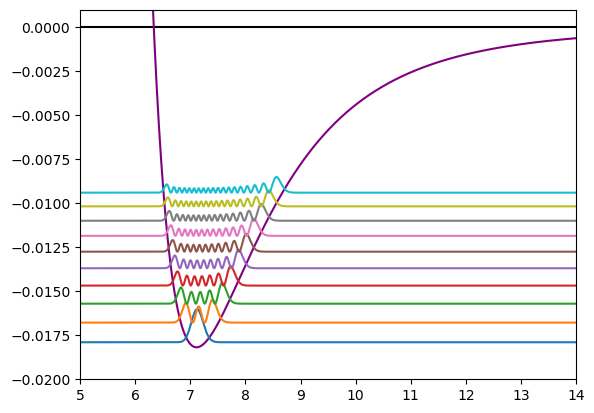

In [112]:
plt.hlines(0,min(x1), max(x1), color = 'black')
plt.plot(x1, VLJ, color = 'purple')
for i in range(20):
    if i % 2 == 0:
        plt.plot(x1, 0.0005*np.abs(Hvec[i])**2 + Heig[i], label=f'n={i}')

plt.ylim(-0.02, 0.001)
plt.xlim(5,14)
#plt.legend()

In [114]:
for i in range(len(Heig[Heig < 0])): # run through all eigenvectors corresponding to bound states
    for j in range(len(Heig[Heig < 0])): # run through all other eigenvectors corresponding to bound states
        
        if i == j: # inner product should be close to 1
            phi_n = np.conjugate(Hvec[i])
            phi_m = Hvec[j]
            produit = phi_n*phi_m
            InnerProduct = np.trapz(produit, x1)
            assert(InnerProduct - 1 <= tol)

        if i != j: # inner product should be close to 0
            phi_n = np.conjugate(Hvec[i])
            phi_m = Hvec[j]
            produit = phi_n*phi_m
            InnerProduct = np.trapz(produit, x1)
            assert(InnerProduct <= tol)

# Numerov Algorithm for continuum states (E > 0)

## Schrodinger in au: -$\frac{1}{2\mu  }\frac{d^2\psi}{dr^2} + (\frac{l(l+1)}{2\mu r^2} + V(r))\psi = E\psi$ 
## $\psi'' = -2\mu(E - \frac{l(l+1)}{2\mu r^2} - V(r))\psi$
## $\implies \psi'' + 2\mu(E - \frac{l(l+1)}{2\mu r^2} - V(r))\psi = 0$
## $\psi'' + k^2(r)\psi = 0$
## define  $k^2(r) = 2\mu(E - V(r) - \frac{l(l+1)}{2\mu r^2})$

## $\psi(r_{n + 1}) - 2\psi(r_{n}) + \psi(r_{n - 1})  + k^2(r_{n})\psi(r_{n}) = 0$


## $\psi(r_{n+1}) = \frac{2(1-\frac{5}{12}(dr)^2k^2_{n})\psi_{n} - (1 + \frac{1}{12}(dr)^2k^2_{n-1})\psi_{n-1}}{1 + \frac{1}{12}(dr)^2k^2_{n+1}}    $

In [28]:
def Numerov(Energy, N): # function to find psi(r)
    psi[0] = 0 # impose boundary condition psi(0) = 0
    psi[1] = dr # let psi(1) = the spacing length
    #print(f' psi[1] = {psi[1]}')
    ksq = 2*mu*(Energy - Vr) # wave number squared for the energy

    for i in range(2,N):  # Numerov Algorithm, range is 2 -> N since psi(0), psi(1) already set
        #if i < 100:
         #   print(f' first term in numerator is {(2*(1 - (5/12)*(dr**2)*k[i-1])*psi[i-1])}')
        psi[i] = ((2*(1 - (5/12)*(dr**2)*ksq[i-1])*psi[i-1]) - ((1 + (1/12)*(dr**2)*ksq[i-2])*psi[i-2]))/(1 + (1/12)*(dr**2)*ksq[i])
    Psi_f = psi/max(psi)
    

            
    return Psi_f

# Energy Normalized Numerov

In [ ]:
def Numerov(Energy, Num, V_r, dr, grid): # function to find psi(r) continuum state (E>0)
    global psi
    psi[0] = 0 # impose boundary condition psi(0) = 0
    psi[1] = dr # let psi(1) = the spacing length
    #print(f' psi[1] = {psi[1]}')
    ksq = 2*mu*(Energy - V_r) # wave number squared for the energy
    ksq_p = 2*mu*Energy
    #print(max(ksq))

    for i in range(2,Num):  # Numerov Algorithm, range is 2 -> N since psi(0), psi(1) already set
        #if i < 100:
       #     print(f' first term in numerator is {(2*(1 - (5/12)*(dr**2)*ksq[i-1])*psi[i-1])}')
        #    print(f' the numerator is {((2*(1 - (5/12)*(dr**2)*ksq[i-1])*psi[i-1]) - ((1 + (1/12)*(dr**2)*ksq[i-2])*psi[i-2]))}')
        psi[i] = ((2*(1 - (5/12)*(dr**2)*ksq[i-1])*psi[i-1]) - ((1 + (1/12)*(dr**2)*ksq[i-2])*psi[i-2]))/(1 + (1/12)*(dr**2)*ksq[i])
        psi = psi/max(psi)
        if i == int(0.5*Num):
            print('halfway there')
        if i == int(0.9*Num):
            print('almost there')
    
    Psi_f = psi/max(psi) # divide Psi by its largest value to qvoid it becoming too large
    Psi_prime = np.gradient(Psi_f, grid) # find the derivate over the grid r
    
    # Energy Normalization
    A_term = Psi_f[-1]**2
    B_term = Psi_prime[-1]**2
    B_coef = 1/(ksq[-1])
    U_sq = A_term + B_coef*B_term
    U = np.sqrt(U_sq)
    norm_factor = np.sqrt((2*mu)*(1/(np.pi*np.sqrt(ksq[-1]))))
    #print((U,norm_factor))
    
    Psi_Energy_Normalized = (1/U)*(Psi_f)*norm_factor
    
        
    return Psi_Energy_Normalized

# Numerov Example - Lennard Jones with E = $1\mu K$

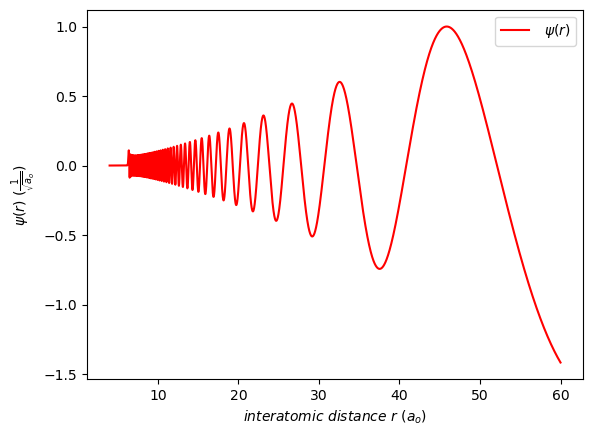

In [35]:
psi = np.zeros(pts)  # initializing psi(r) as array of zeros
Psi_1 = Numerov(Eo, pts) # wave function Psi
psi_1prime = np.gradient(Psi_1, r) # first posistion derivate of wave function Psi
plt.plot(r, Psi_1, label = f' $\\psi(r)$', color = 'red') 
#plt.plot(r, Vr*1e0, label = 'Scaled Lennard-Jones Potential', color = 'purple')
plt.xlabel('$ interatomic$ $distance$ $r$ $(a_{o})$')
plt.ylabel('$\\psi(r)$ ($\\frac{1}{\\sqrt{a_{o}}}$)')
plt.legend()

# Photoassociation

## $K = \frac{\Gamma /2 }{E_o - (\hbar \omega - E_b) + i \gamma/2 }$
## $\Gamma = 2 \pi U^2 |\braket{\varphi_b|\psi_s}|^2 = 2 \pi U^2 | \int_{r1}^{r2} \varphi_{b}^* \cdot \psi$ $ dr |^2 $
## $U = E_od_t = E_oea_o$, $E_o \propto \sqrt{I}$
## $S = \frac{1 + iK}{1 - iK} $
## $\sigma = 1 - |S|^2$

# Photoassociation Cross section $\sigma$

In [ ]:
def Sigma_PA_hw(omega_range, C12_coef, Bound_States, Bound_Energies, Collision_E): # calculate cross section over a range of laser frequencies
    
    VLJ_PA = (C12_coef/(R_grid**12)) - (C6/(R_grid**6))
    Psi_Scattering = Numerov(Eo, N_big - 1, VLJ_PA, dr1, R_grid)
    #plt.plot(r_grid, Psi_Scattering[r1_i + 1:r2_i - 1])
    wave_num_sq = 2*mu*Eo
    
    #Bound_Eigen_energies = Bound_Energies
    #print(Bound_Eigen_energies)
    #Bound_Eigen_vecs = [ [] for i in range(len(Hamiltonian_eigvals_eigvecs)) ]
    #print(Bound_Eigen_vecs)
    K_N = []
    Gamma_vals = []
    FC_vals = []

   # for i in range(len(Bound_States)):
   #     #print(i)
   #     for j in range(len(Bound_States[i])):
            #print(comparison_n)
   #         Bound_Eigen_energies[i].append(Hamiltonian_eigvals_eigvecs[i][0][j]) # collect all eigenvalues of the ith Hamiltonian
   #         Bound_Eigen_vecs[i].append(Hamiltonian_eigvals_eigvecs[i][1][j]) # collect all eigenvectors of the ith Hamiltonian
   # for i in range(len(Hamiltonian_eigvals_eigvecs)):
   #     for j in range(len(Bound_Eigen_energies[i])):
   #         Bound_Eigen_energies[i][j] = H_to_GHz*Bound_Eigen_energies[i][j]
    #print(Bound_Eigen_energies[0])
    #print(Bound_Eigen_energies[1])
    #num_of_states = []
    #for i in range(len(Bound_States)):
    #    num_of_states.append(len(Bound_States[i]))
    #for i in range(len(num_of_states)):
    #    if num_of_states[i] == max(num_of_states):
    #        Key_B_for_G = Bound_States[i][num_of_states[i] - 1]
    #        print(f'max bound state is from potential {i}, n = {num_of_states[i]}')
    
    #Gamma0 = 100*gamma
    #FC0 = np.abs(np.trapz(np.conjugate(Key_B_for_G)*Psi_Scattering[r1_i + 1:r2_i - 1], r_grid))**2
    
    #U_squared = Gamma0/(2*np.pi*FC0)
    #print(f'U^2 = {U_squared}')
    U_squared = E_0**2
    for i in range(len(Bound_States)):
        for j in range(len(Bound_States[i])):
           # if  j == 1 or j == 3:
            FC_n = np.abs(np.trapz(np.conjugate(Bound_States[i][j])*Psi_Scattering[r1_i + 1:r2_i - 1], r_grid))**2
            FC_vals.append([FC_n, i, j])
            Gamma_n = 2*np.pi*U_squared*FC_n
            Gamma_vals.append(Gamma_n)
            
        #plt.hlines(Gamma_n, -Gamma_n,Gamma_n, color = 'black')
        #print(f'n = {i}, Gamma/gamma = {Gamma_n/gamma}')
                    #print(f'VE{i}, n = {j}, Gamma = {Gamma_n}, Eb = {Bound_Eigen_energies[i][j]}')
            
            Kn_num = -1*(Gamma_n*0.5)
        #print(f'Kn numerator = {Kn_num}')
        #Delta = omega_range - Bound_Eigen_energies[i]
        #print(f' Delta[0] = {Delta[0]}')
            Detuning = (omega_range - H_to_GHz*Bound_Energies[i][0][j])
            Kn_den = (H_to_GHz*Collision_E - Detuning) + I*gamma*0.5
        #print(f'Kn denominator = {Kn_den}')
            Kn = np.array((Kn_num/Kn_den))
        #print(f'n= {i}, Kn = {Kn}')
            K_N.append(Kn)
    #print(f' K_N = {K_N}')

    K = sum(K_N)
    #plt.plot(omega_range,np.imag(K), color = 'purple')
    #print(f'K = Sum(K_N) = {K}')
    #print(np.real(K))
    #print(np.imag(K))
    
    S_num = 1 + I*K
    #print(f'S numerator = {S_num}')
    S_den = 1 + -1*I*K
    #print(f'S denominator = {S_den}')
    S = S_num/S_den
    #print(f'S = {S}')
    S_prob = 1 - np.absolute(S)**2
   # print(f' |S|^2 = {np.absolute(S)**2}')
   # print(f'1 - |S|^2 = {S_prob}')

    #Sigma_PA_2 = (np.pi/wave_num_sq)*(S_prob)
    Sigma_PA_frequency = (S_prob)
    
    
    return(Sigma_PA_frequency, Gamma_vals, FC_vals)

# Other Algorithms

# Scattering length definition

# $-\frac{1}{a_s} = \lim\limits_{k \to 0}$ $ k\cot(\delta) $
## $ k = \frac{\sqrt{2\mu(E - V(r))}}{\hbar}$
## $a_{s} =  \sqrt{\frac{\sigma}{\pi}}$ given $(E\ll Vo)$
## $\delta = -ka_{s}$ given $(E\ll |Vo|)$


# Finding the scattering phase shift $\delta$ 

## $\psi_{LR}(r) \propto\sin(kr + \delta)$
## $\frac{d\psi}{dr} = k \cos(kr + \delta)$
## $\frac{\psi}{\frac{d\psi}{dr}} = \frac{1}{k} \tan(kr + \delta)$
## $\tan^{-1}(\frac{k\psi_{n}}{\frac{d\psi_{n}}{dr}}) = kr + \delta$
## $\delta = \tan^{-1}(\frac{k\psi_{n}}{\frac{d\psi_{n}}{dr}}) - kr $
## $\delta = \tan^{-1}(\frac{k\psi_{n}}{\frac{d\psi_{n}}{dr}}) - kr $

# Finding Scattering Length $a_s$

## $\delta = \tan^{-1}(\frac{k\psi_{n}}{\frac{d\psi_{n}}{dr}}) - kr $ = $-ka_s$

In [ ]:
Delta_numeric = []
knsq = []
as_delta = []
for j in range(N):
    for i in range(N):
        ksq = 2*mu*(E[i] - Vr)
        knsq.append(ksq[-1])
        PSI = Numerov(E[i],N) # wave function to find using Numerov
        PSI_prime = np.gradient(PSI, r) # find derivative of PSI Numerov
        Delta = np.arctan((np.sqrt(ksq)*PSI)/(PSI_prime)) - np.sqrt(ksq)*r
        Delta_numeric.append(Delta[-1])
        as_delta.append(Delta_numeric[-1]/np.sqrt(knsq[-1]))

In [ ]:
def wavefunction_LJ(Energy, M, rmin, rmax, h, C6, C12): # Numerov method function to find psi(r)
    r_range = np.linspace(rmin, rmax, M)
    VLJ = (C12*(1/r_range**12)) - (C6*(1/r_range**6))
    psi[0] = 0 # impose boundary condition psi(0) = 0
    psi[1] = dr # let psi(1) = the spacing length
    #print(f' psi[1] = {psi[1]}')
    ksq = 2*mu*(Energy - VLJ) # wave number squared for the energy
    ksq_p = 2*mu*Energy

    for i in range(2,M):  # Numerov Algorithm, range is 2 -> N since psi(0), psi(1) already set
        #if i < 100:
           # print(f' first term in numerator is {(2*(1 - (5/12)*(dr**2)*ksq[i-1])*psi[i-1])}')
           # print(f' the numerator is {((2*(1 - (5/12)*(dr**2)*ksq[i-1])*psi[i-1]) - ((1 + (1/12)*(dr**2)*ksq[i-2])*psi[i-2]))}')
        psi[i] = ((2*(1 - (5/12)*(dr**2)*ksq[i-1])*psi[i-1]) - ((1 + (1/12)*(dr**2)*ksq[i-2])*psi[i-2]))/(1 + (1/12)*(dr**2)*ksq[i])
    Psi_f = psi/max(psi) # divide Psi by its largest value to qvoid it becoming too large
    Psi_prime = np.gradient(Psi_f, r_range) # find the derivate over the grid r
    
    # Energy Normalization
    A_term = Psi_f[-1]**2
    B_term = Psi_prime[-1]**2
    B_coef = 1/(ksq[-1])
    U_sq = A_term + B_coef*B_term
    U = np.sqrt(U_sq)
    norm_factor = np.sqrt((2*mu)*(1/(np.pi*np.sqrt(ksq[-1]))))
    #print((U,norm_factor))
    
    Psi_Energy_Normalized = (1/U)*(Psi_f)*norm_factor
    
        
    return Psi_Energy_Normalized

In [ ]:
def Psilinear(wavefct, r_range):
    
    
    m = (wavefct[-1] - wavefct[-2])*(1/(r_range[-1] - r_range[-2]))
    b = wavefct[-1] - (m*r_range[-1])
    y = m*r_range + b
    ro = -b/m
    return [y,ro]

C12I = 3e12 # C12 coefficient in Eh*ao
C6I = 2e5 # C6 coefficient in Eh*ao

#linepsi = Psilinear(rr)
#plt.plot(rr, linepsi[0], label = 'f(r) trace', color = 'lightsalmon')
Eo = 3.166808534191e-12 #initial energy in Hartrees, Eo = 1uK
r1 = 12 # starting iteration distance in ao
r2 = 1300 # ending iteration distance ao
numpts = int(((r2 - r1)*(1/dr)) + 1) # number of points between r1, r2 given step size dr
rr = np.linspace(r1,r2, numpts) # radial distance grid

# Example: Scattering Length for NaK-NaK LJ potential

In [ ]:
R1 = 12 # starting posistion r1 in ao
R2 = 1300 # ending posistion r2 in ao
dr1 = 0.03 # step spacing in ao

scattering_lengths = [0.010243933287286469, 0.4873523651021366, 0.9643725116439043, 1.441312767422435, 1.9181724451562245, 2.394953630118453, 2.8716615474108025, 3.348296313448165, 3.8248612410539, 4.301360191592009, 4.777792639029653, 5.254164555954798, 5.730474548616693, 6.206729647224365, 6.6829288493721215, 7.159075704841968, 7.635173260432172, 8.111223270257588, 8.587230361427139, 9.063191776915149, 9.539115214191163, 10.015002840214505, 10.490854287511935, 10.966673818894973, 11.442465949159418, 11.918228143869618, 12.393966209805264, 12.869684147390949, 13.34538022267255, 13.82105979938738, 14.296722807110191, 14.772377285615148, 15.24801993112512, 15.723656947411651, 16.199289095845806, 16.674915822194347, 17.15054774197515, 17.62617987661916, 18.10181599913844, 18.577463171498064, 19.053117991345182, 19.528788648186165, 20.004472094540006, 20.480173707927946, 20.95589533592249, 21.431641549724002, 21.907411806707586, 22.38320859235713, 22.859039090583074, 23.33490041419705, 23.810796682590784, 24.286731296040788, 24.762706267011453, 25.23872282556908, 25.714786190464615, 26.19089602290096, 26.66705855562812, 27.143273083314984, 27.61954244292049, 28.09586756449882, 28.572255023296893, 29.048705266476535, 29.525221788898094, 30.001805420080423, 30.47845878465603, 30.955186160482185, 31.431986785084927, 31.908866701470473, 32.38582880836695, 32.86287173301145, 33.340000383543284, 33.8172172530004, 34.29452391890193, 34.77192505501657, 35.249422841414976, 35.72701614800537, 36.204712037442896, 36.68250926520692, 37.16041219110842, 37.63842505998282, 38.11654776376449, 38.59478449034806, 39.07313557001021, 39.55160596161139, 40.03019733278185, 40.508913413721864, 40.987753639014265, 41.466723064307686, 41.94582338074626, 42.425058781824944, 42.9044284458334, 43.38393808823367, 43.86359002188373, 44.34338546267951, 44.82332667008387, 45.30341926519018, 45.78366121369357, 46.264057260140945, 46.74461196396646, 47.22532547248042, 47.706201553785846, 48.18724084171159, 48.66844880747044, 49.14982606087591, 49.63137607679283, 50.11310196680164, 50.595004369316506, 51.077087127703265, 51.5593541070769, 52.0418058329455, 52.52444695666022, 53.00727582161, 53.4903014516339, 53.97352151236108, 54.45694124953146, 54.9405620508971, 55.424388064301965, 55.90841826784163, 56.39265944309781, 56.87711252457353, 57.36178031217024, 57.84666628958561, 58.331770796390934, 58.81709868388262, 59.30265247641235, 59.78843404041795, 60.27444677908272, 60.760693982259475, 61.24717560055766, 61.73389702633933, 62.220860560630776, 62.70806799816175, 63.19552242358453, 63.68322781416185, 64.17118485389734, 64.65939768228783, 65.14786737575837, 65.63660036769662, 66.12559447749094, 66.61485663676187, 67.10438715366207, 67.59418829143821, 68.08426767265931, 68.57462236965868, 69.06525744138872, 69.55617569839083, 70.04737954232017, 70.53887195363104, 71.03065630505743, 71.52273589914996, 72.01511150806074, 72.507788055974, 73.00076708315784, 73.49405132577131, 73.98764388237757, 74.48154873412035, 74.97576695490044, 75.47030418556159, 75.96516186095123, 76.4603400911137, 76.95584455177679, 77.45167904798608, 77.94784434180939, 78.44434329915727, 78.94118194817752, 79.43835955143432, 79.93588124760818, 80.43374878353414, 80.93196581165878, 81.4305346580115, 81.92945876984288, 82.42874129487817, 82.92838609505777, 83.42839410572923, 83.92876984148428, 84.42951414678376, 84.93063337691021, 85.4321281413273, 85.93400249002526, 86.43625845245509, 86.93890146771123, 87.44193183439407, 87.94535317651142, 88.44916999404354, 88.95338453428, 89.45799923632694, 89.96301828352306, 90.46844365682327, 90.97427982468777, 91.48052727561236, 91.98719450634647, 92.49427921463946, 93.00178605862386, 93.50971967897638, 94.01808246210972, 94.52687821898968, 95.03610728733759, 95.54577669179405, 96.05588692408193, 96.56644247187432, 97.07744729452007, 97.58890354673495, 98.10081386571491, 98.61318392928719, 99.12601214133092, 99.63930718887887, 100.15306888413542, 100.66730366581939, 101.18201126477696, 101.69719762918938, 102.2128653343598, 102.72901786449268, 103.24565866812986, 103.76279016726653, 104.28041661125361, 104.79854107760842, 105.31716647589325, 105.83629754384846, 106.35593826613167, 106.87608840208595, 107.39675495479455, 107.91793978364501, 108.4396483297929, 108.96188192879382, 109.48464465570578, 110.00794036981826, 110.53177313651156, 111.05614465287499, 111.58105884861742, 112.10652187691754, 112.63253561876336, 113.15910209855177, 113.68622693251031, 114.21391340130363, 114.74216436996488, 115.27098428968658, 115.80037719613999, 116.33034526776723, 116.86089362740975, 117.39202565599301, 117.9237442244708, 118.45605375898818, 118.98895820111028, 119.52246196830599, 120.05656715384583, 120.59127746140227, 121.12659829584327, 121.66253298294014, 122.19908429865646, 122.73625802805397, 123.27405559002858, 123.81248371989635, 124.35154344737124, 124.89124062349492, 125.43157754547767, 125.97256097583531, 126.51419230707343, 127.05647566311687, 127.59941590012227, 128.1430172981426, 128.68728434591992, 129.23221808964723, 129.77782599129773, 130.32410943447033, 130.87107478080927, 131.41872370427697, 131.96706380556836, 132.51609591267132, 133.06582589190657, 133.6162587876039, 134.1673959660176, 134.71924447299568, 135.2718056788325, 135.82508525081394, 136.37908926664508, 136.93381899528322, 137.48928131422093, 138.04547926535, 138.6024162978967, 139.16009792754008, 139.71852944594596, 140.2777126881382, 140.837654977147, 141.3983580184772, 141.9598289836876, 142.52206986879912, 143.08508696998487, 143.64888448400632, 144.213464538283, 144.77883604971748, 145.34499995035821, 145.91196232310438, 146.47972745721262, 147.04830072096314, 147.6176862402907, 148.1878875127127, 148.7589104294252, 149.33076102623187, 149.90344268006345, 150.4769597898006, 151.05131790814266, 151.62652194827714, 152.20257524062055, 152.77948394698805, 153.35725246041932, 153.93588790458057, 154.51539172419217, 155.09577084574872, 155.67702947217694, 156.2591728434718, 156.8422071870045, 157.4261354930936, 158.01096478324857, 158.59669829045967, 159.18334207561333, 159.77090247588825, 160.35938286131227, 160.94879021497712, 161.53912686368562, 162.13040119376538, 162.72261628504546, 163.31577827020163, 163.90989292269097, 164.5049650953075, 165.10100126504457, 165.69800429133943, 166.29598230476788, 166.89493863737837, 167.49488134532075, 168.09581282759143, 168.69774112419114, 169.3006704387582, 169.90460831893745, 170.50955810241794, 171.11552591970377, 171.7225191220737, 172.33054115066818, 172.93959877180177, 173.54969778647475, 174.16084612981902, 174.7730452838758, 175.38630392924637, 176.00062708905486, 176.61602314730715, 177.23249318631454, 177.85004843662398, 178.46869076654016, 179.0884289194886, 179.70926898684007, 180.33121586354218, 180.95427630608873, 181.5784548496845, 182.20376113824082, 182.8301991294351, 183.45777518701286, 184.08649574088733, 184.71636778273233, 185.34739680929897, 185.97959055755214, 186.61295440309127, 187.247495410913, 187.88322087977292, 188.5201349800448, 189.1582464404965, 189.79756307705082, 190.4380871743748, 191.07982982042247, 191.7227955652753, 192.36699102115645, 193.0124246608664, 193.6591027599159, 194.3070318507054, 194.95621908637557, 195.6066708946244, 196.25839511029776, 196.9114006763734, 197.56569003636412, 198.2212735357997, 198.8781594641901, 199.53635148045157, 200.19585902202715, 200.85669111296204, 201.51885157028735, 202.18234983408834, 202.8471936160837, 203.51339008529106, 204.18094497006538, 204.84986811354597, 205.52016872376606, 206.19185135797142, 206.86492419834474, 207.53939641922602, 208.21527413737905, 208.89256635969946, 209.57128116149886, 210.25142584244418, 210.93300963815815, 211.6160379140297, 212.3005210149082, 212.98646888014585, 213.67388549312852, 214.36278217218728, 215.05316501872377, 215.74504456477302, 216.43842859851176, 217.13332496661602, 217.82974329124013, 218.5276904173623, 219.22717536170128, 219.92820850060258, 220.63079697759568, 221.33494970103985, 222.0406768116402, 222.74798670440856, 223.45688704456106, 224.16738804407652, 224.87949923795082, 225.59322837871449, 226.30858503569638, 227.02557990575906, 227.74422031103893, 228.4645159178484, 229.18647655680124, 229.91011421904375, 230.63543354655476, 231.36244806832602, 232.09116405827064, 232.82159641169838, 233.5537506559357, 234.2876375847949, 235.0232663896402, 235.76064780151367, 236.499793932053, 237.24071202164384, 237.9834143617017, 238.72790856458013, 239.47420853995493, 240.22232041377336, 240.97225833730482, 241.7240310901417, 242.477650257855, 243.23312367063488, 243.9904666827002, 244.74968682992773, 245.51079545538073, 246.2738056137768, 247.03872445898543, 247.8055663432477, 248.57434172398123, 249.34506164874887, 250.1177375137001, 250.8923799812306, 251.66900210176613, 252.44761309522218, 253.22822726844768, 254.01085462453347, 254.7955069728898, 255.58219883129848, 256.3709382635058, 257.16173969409715, 257.95461326184693, 258.74957407100754, 259.54663318482403, 260.3458029005833, 261.1470954949346, 261.9505238785407, 262.7561004372387, 263.5638373307252, 264.3737483036547, 265.18584775116847, 266.00014530348676, 266.81665670329375, 267.635393586888, 268.45637121913785, 269.27960071404743, 270.1050982066141, 270.93287362432756, 271.7629441463618, 272.5953216928969, 273.43002069069917, 274.26705505199027, 275.1064402075846, 275.94818772452976, 276.79231341185977, 277.6388325470098, 278.4877573539524, 279.33910481828855, 280.1928880699898, 281.04912248357067, 281.90782441971214, 282.76900688861986, 283.63268546438803, 284.4988753256292, 285.3675928405959, 286.2388531342547, 287.1126711869821, 287.98906401516774, 288.86804645200345, 289.7496343924739, 290.633844876558, 291.520694368979, 292.41019735568676, 293.3023714209024, 294.19723382476826, 295.09480046868066, 295.99508782421384, 296.89811419318397, 297.803896630829, 298.7124510925628, 299.62379558125036, 300.5379483977347, 301.4549267595608, 302.3747479193606, 303.29743002538373, 304.2229912910382, 305.1514501781062, 306.0828246301343, 307.0171336494845, 307.9543949040497, 308.89462973144964, 309.83785442498515, 310.7840884708598, 311.73335257274243, 312.6856651225578, 313.6410455625522, 314.59951348748194, 315.5610898816685, 316.5257934582108, 317.49364566424913, 318.4646663716179, 319.4388758235692, 320.4162956984935, 321.39694481065095, 322.3808469232314, 323.36802121924273, 324.35848936519943, 325.3522746190682, 326.3493963362501, 327.3498785275758, 328.3537416687221, 329.36100858518995, 330.3717026250312, 331.3858453853468, 332.40346026175183, 333.4245703982246, 334.4491982753458, 335.47736817489175, 336.5091037641109, 337.5444283151091, 338.5833664968412, 339.6259411604706, 340.6721796509128, 341.7221036939275, 342.77573916293744, 343.83311150389386, 344.89424628172253, 345.95916761761544, 347.02790297682645, 348.10047709756867, 349.1769167455346, 350.25724845498377, 351.34149913297153, 352.4296936650084, 353.5218621135109, 354.61803041667656, 355.71822545467217, 356.8224758460832, 357.9308096537607, 359.0432550516113, 360.1598421682024, 361.28059762953876, 362.405551621568, 363.53473257136204, 364.66817147742745, 365.8058973502118, 366.947940543777, 368.09433260958565, 369.2451018859776, 370.4002823354854, 371.55990218993145, 372.7239946889834, 373.8925923234341, 375.0657259809348, 376.24342844086294, 377.4257331578366, 378.61267238950455, 379.80427910818935, 381.0005877061761, 382.20163229178024, 383.40744653442584, 384.6180654445961, 385.8335246796197, 387.0538569973784, 388.2791015150061, 389.50929217525555, 390.74446512516147, 391.98465711508385, 393.2299059676056, 394.4802478439961, 395.73572114815613, 396.9963647314122, 398.26221426586784, 399.53331155289675, 400.809694202277, 402.0914021941587, 403.378474619684, 404.6709533579408, 405.9688784115559, 407.2722905075449, 408.5812310822589, 409.8957426658638, 411.2158676365216, 412.5416472186968, 413.8731266758949, 415.2103490097566, 416.55335679205547, 417.9021964441887, 419.25691184356856, 420.6175487309604, 421.9841525136071, 423.35677017225737, 424.73544843370473, 426.12023356550765, 427.5111743923546, 428.9083182729854, 430.3117147353441, 431.7214126118493, 433.1374609650059, 434.5599110929614, 435.9888128737002, 437.42421824539485, 438.866178599724, 440.3147461812675, 441.7699748337447, 443.2319163248905, 444.7006265291955, 446.176157891554, 447.6585678666471, 449.1479103508463, 450.6442431643809, 452.14762140932226, 453.65810415434447, 455.1757494929407, 456.7006153171784, 458.2327616314753, 459.77224855892194, 461.31913677339634, 462.87348746721125, 464.4353624784426, 466.0048240792927, 467.5819372018381, 469.1667650150722, 470.75937244754704, 472.35982453626815, 473.9681878371414, 475.5845297291879, 477.2089176876186, 478.8414203594012, 480.48210645252954, 482.13104601755714, 483.788311056922, 485.4539715875987, 487.1281008934552, 488.81077290862356, 490.50206008608853, 492.20203821744, 493.9107832116796, 495.6283717961033, 497.35488139977554, 499.09039006989394, 500.8349781672218, 502.58872477834615, 504.3517115422687, 506.124021248841, 507.9057364145828, 509.6969415102369, 511.4977214343725, 513.308162308497, 515.1283508923614, 516.9583763489826, 518.7983271553393, 520.6482941812467, 522.5083681726913, 524.3786417578145, 526.2592090901738, 528.1501644770775, 530.051604250504, 531.9636247962928, 533.8863246601258, 535.8198037768299, 537.7641623395195, 539.7195027893439, 541.6859277828366, 543.6635424594361, 545.6524521406129, 547.6527638030115, 549.6645867001251, 551.6880302924719, 553.7232055440463, 555.7702252771646, 557.8292036304274, 559.9002566449404, 561.9835003683905, 564.079053742129, 566.1870373482004, 568.307572381884, 570.440781148964, 572.5867902388991, 574.7457253829706, 576.9177139557798, 579.1028864797637, 581.3013741628243, 583.5133100550373, 585.7388296524639, 587.9780693811266, 590.2311678857411, 592.4982657694555, 594.7795056787301, 597.0750309, 599.3849896662376, 601.7095279755727, 604.0487974064386, 606.4029496211966, 608.7721398791388, 611.1565241645065, 613.5562612545361, 615.9715124608135, 618.4024407379147, 620.8492109173743, 623.3119915157315, 625.7909529478154, 628.2862666568504, 630.7981086123946, 633.326656001384, 635.8720885351287, 638.4345895256445, 641.0143437400667, 643.611539107721, 646.226366414365, 648.8590188992736, 651.5096932037952, 654.178587939678, 656.8659053400751, 659.5718508141707, 662.296631463457, 665.0404597010689, 667.8035489685207, 670.5861170772421, 673.3883847528924, 676.2105765150442, 679.0529194373291, 681.9156449431864, 684.7989870251976, 687.7031843644495, 690.6284785678017, 693.5751150484434, 696.5433435486949, 699.5334165311051, 702.5455919875485, 705.5801310195716, 708.6372983695561, 711.7173644921023, 714.8206027498117, 717.9472912322105, 721.0977129102052, 724.272154513676, 727.4709086396283, 730.6942715036865, 733.9425439554724, 737.2160335900364, 740.5150506581111, 743.8399118237002, 747.1909392922001, 750.5684597908125, 753.9728061356988, 757.4043161194634, 760.8633335885294, 764.3502086324544, 767.8652962342213, 771.4089580317502, 774.9815623539781, 778.5834827706612, 782.2150999714522, 785.8768015288805, 789.5689810677318, 793.2920390895545, 797.0463842121401, 800.8324307456944, 804.6506014855502, 808.5013265023218, 812.3850431389105, 816.3021973999132, 820.2532418155048, 824.2386392602275, 828.25885891746, 832.3143804528135, 836.4056909730302, 840.5332871962516, 844.69767465179, 848.8993685069149, 853.138894331751, 857.4167859530488, 861.7335890431598, 866.0898580664572, 870.4861592043743, 874.9230691482674, 879.4011751714269, 883.9210770517269, 888.4833850199021, 893.0887223991762, 897.7377232080235, 902.4310363889059, 907.1693204609464, 911.953250392396, 916.7835127529166, 921.6608081643088, 926.5858517953756, 931.5593737687205, 936.5821171729717, 941.6548434889195, 946.778326982877, 951.9533599830379, 957.1807502257213, 962.4613230467983, 967.7959209588024, 973.185404210904, 978.6306516647842, 984.1325610517487, 989.6920489342173, 995.310052192919, 1000.9875284214351, 1006.7254551750883, 1012.52483261128, 1018.3866826923719, 1024.3120493401482, 1030.302001464717, 1036.3576310009812, 1042.4800546675483, 1048.6704148046088, 1054.9298793205978, 1061.2596438266114, 1067.6609321269596, 1074.1349950306515, 1080.6831143643751, 1087.306600488875, 1094.0067958021307, 1100.7850758226407, 1107.6428461878027, 1114.5815490949255, 1121.6026607952679, 1128.7076940374986, 1135.8981983483418, 1143.1757617411358, 1150.5420122527505, 1157.9986182169162, 1165.5472895528803, 1173.1897810516434, 1180.9278912382945, 1188.763465694583, 1196.6983958114956, 1204.734625285072, 1212.8741469009997, 1221.119004809271, 1229.4713009444008, 1237.9331907135706, 1246.506887607613, 1255.194666873315, 1263.9988642707553, 1272.921881148551, 1281.9661844208583, 1291.13430896155, 1300.428862621693, 1309.852524605376, 1319.4080527202404, 1329.0982834118283, 1338.926132305988, 1348.8946052332103, 1359.006790694945, 1369.2658696917983, 1379.675120241201, 1390.2379172995347, 1400.9577342446735, 1411.838157140085, 1422.88287377637, 1434.0956933643859, 1445.4805375308156, 1457.041454802746, 1468.7826205869712, 1480.7083449898207, 1492.8230709959066, 1505.1313906435619, 1517.638046825321, 1530.3479310127384, 1543.266107391563, 1556.397801981811, 1569.7484179252995, 1583.3235475034776, 1597.1289677389912, 1611.1706619770557, 1625.4548172975788, 1639.987844439611, 1654.7763748321263, 1669.827283482529, 1685.1476933283927, 1700.7449851247054, 1716.626810459468, 1732.8011144077084, 1749.276129634287, 1766.0604040645253, 1783.162819469915, 1800.5925872382816, 1818.3592915677684, 1836.472885453911, 1854.9437238567602, 1873.7825743476317, 1893.0006398318737, 1912.6095884983765, 1932.6215659404581, 1953.0492315643032, 1973.9057745447647, 1995.204953446636, 2016.9611208724195, 2039.1892542772132, 2061.904991035775, 2085.124672388259, 2108.865378917069, 2133.1449591806063, 2157.982100022594, 2183.3963634564197, 2209.408223744523, 2236.0391495188564, 2263.3116387533905, 2291.2493004306043, 2319.8769111434185, 2349.220504005543, 2379.3074225659316, 2410.166430502633, 2441.8277930507593, 2474.323380740856, 2507.6867721012063, 2541.9533651044676, 2577.16052308571, 2613.347694616906, 2650.5565593174815, 2688.8311911252813, 2728.2182534015265, 2768.767163124245, 2810.5303069856727, 2853.5632682802516, 2897.925078863686, 2943.678476382861, 2990.890232416974, 3039.6314553977377, 3089.977932683127, 3142.0105488368977, 3195.8157459560052, 3251.485927157882, 3309.1200793274784, 3368.824276631742, 3430.712411522522, 3494.9068737207044, 3561.5393642863532, 3630.7517936087183, 3702.6973444900045, 3777.541538257416, 3855.4635473196818, 3936.6576212938116, 4021.334723437044, 4109.7242786294455, 4202.076447229299, 4298.664236663204, 4399.786417710327, 4505.77049554385, 4616.976334960557, 4733.800172784371, 4856.679343446507, 4986.097921291485, 5122.592806098923, 5266.761450113201, 5419.27047396001, 5580.866023377722, 5752.385973554013, 5934.774409042896, 6129.0993173605475, 6336.572972253775, 6558.57792440393, 6796.697483600763, 7052.75338952287, 7328.853156717169, 7627.447608058487, 7951.404249170974, 8304.099596679343, 8689.537270935032, 9112.500834605511, 9578.7534218915, 10095.301913762944, 10670.751487995129, 11315.789292543688, 12043.854169593087, 12872.083998163349, 13822.680874845959, 14924.932809161102, 16218.283989406891, 17757.157333211042, 19618.8068407964, 21916.695047676945, 24824.525580865167, 28622.331336234776, 33792.54781852988, 41243.19780536486, 52909.980971419114, 73783.8026582974, 121867.33904606423, 349943.4862405092, -401439.2928803996, -127546.05115429439, -75813.69634152847, -53935.01256476836, -41854.76723440546, -34194.830193098125, -28904.24871519291, -25030.925397653085, -22072.626492345145, -19739.349886427553, -17851.934155756375, -16293.71885804681, -14985.479140601761, -13871.523090919462, -12911.55926896538, -12075.716501949866, -11341.380164058355, -10691.114920093758, -10111.26286565996, -9590.971344462701, -9121.510302689165, -8695.775431616265, -8307.927776893142, -7953.123532749336, -7627.310891914787, -7327.074551363843, -7049.515373218095, -6792.156182787008, -6552.8682939567025, -6329.811789628474, -6121.38830180511, -5926.2027684002915, -5743.031791583456, -5570.79852673318, -5408.550672166965, -5255.443837179024, -5110.725791821377, -4973.724943257231, -4843.839370329269, -4720.528190508865, -4603.304011194052, -4491.726499240629, -4385.396642841511, -4283.952296656972, -4187.063911801951, -4094.4308231552277, -4005.7781931026543, -3920.8546379530403, -3839.4291296612114, -3761.289635895171, -3686.240810461128, -3614.1024520438154, -3544.7081104357694, -3477.9039181242088, -3413.5471591127916, -3351.5054112092103, -3291.655729126643, -3233.883663677841, -3178.0826380562553, -3124.153166208019, -3072.0024348308916, -3021.5435894947414, -2972.695374564354, -2925.3816693058548, -2879.53108281012, -2835.076550721552, -2791.9550566944417, -2750.107324837642, -2709.477527939348, -2670.013068978826, -2631.6643590154304, -2594.384559203964, -2558.129390266364, -2522.857033296425, -2488.527889181556, -2455.104452928611, -2422.5511762426836, -2390.8344209269144, -2359.9221301653674, -2329.783982761132, -2300.391084717789, -2271.716024731125, -2243.732653854178, -2216.416137580162, -2189.7427641159647, -2163.689980850243, -2138.2362517690053, -2113.361021935997, -2089.0446710512824, -2065.2684706030627, -2042.0144907807596, -2019.2656247775342, -1997.0054622744594, -1975.2183205102315, -1953.8892050608831, -1933.0036805287589, -1912.5479646452595, -1892.5088419847452, -1872.8736066343959, -1853.6301016052282, -1834.7665799713202, -1816.271843177142, -1798.1350859597326, -1780.3459284275416, -1762.8943871385911, -1745.7708519425314, -1728.9660715460057, -1712.4711715635913, -1696.2775891887209, -1680.3770189715858, -1664.7615474278412, -1649.423465217524, -1634.3554133695914, -1619.5502114571088, -1605.0010063952775, -1590.7011308358383, -1576.6441467025606, -1562.8238538209905, -1549.2342821401276, -1535.8696211510378, -1522.7242665928006, -1509.7927976759868, -1497.0699933192332, -1484.5507737260987, -1472.2302210033702, -1460.103591260803, -1448.1662990225134, -1436.4138620447968, -1424.8419780654792, -1413.4464512506422, -1402.2232437942478, -1391.1684105841905, -1380.2781423745184, -1369.5487320954117, -1358.9765996842532, -1348.5582605204208, -1338.2903377487983, -1328.1695256027233, -1318.1926517889538, -1308.3566348913712, -1298.6584385566784, -1289.0951603845822, -1279.6639382634442, -1270.3620269983276, -1261.1867441730826, -1252.1354621560743, -1243.2056399959506, -1234.3948321215544, -1225.7006090797238, -1217.1206343836257, -1208.652630247121, -1200.2943864733077, -1192.0437297804624, -1183.8985636844304, -1175.856838161009, -1167.9165570198265, -1160.07577624994, -1152.3325964637363, -1144.68517449359, -1137.1316997500492, -1129.6704200598206, -1122.2996262546874, -1115.0176410983938, -1107.822835162192, -1100.7136172298715, -1093.6884429918227, -1086.7457821228152, -1079.884164549887, -1073.1021510067783, -1066.3983321371054, -1059.7713147711847, -1053.2197716129615, -1046.7423795177215, -1040.3378730755235, -1034.0049729524546, -1027.7424668649778, -1021.5491532116434, -1015.4238689119254, -1009.3654806993633, -1003.372842090844, -997.4448811637031, -991.5805114845259, -985.7787020363155, -980.038422661489, -974.3586705354322, -968.738469735248, -963.1768534626896, -957.6728970043334, -952.2256734919349, -946.8342934762408, -941.4978601243328, -936.2155232293384, -930.9864354380173, -925.8097818298908, -920.6847237006189, -915.6105041871807, -910.5863234548536, -905.6114270854424, -900.6850735188252, -895.8065279147058, -890.9750705119441, -886.1900083293957, -881.4506448421299, -876.7563183951363, -872.1063476564835, -867.5001072501972, -862.936944479809, -858.4162412151946, -853.9373931449229, -849.4997769820878, -845.1028294171326, -840.7459636291413, -836.4286148653765, -832.1502297923918, -827.9102465253155, -823.70815491313, -819.543407214491, -815.415501543135, -811.3239272149458, -807.2681862183498, -803.2477898527986, -799.2622643056189, -795.3111282395727, -791.3939321185301, -787.5102134923834, -783.6595260261917, -779.8414324266441, -776.0554983749724, -772.3013162896743, -768.5784617297303, -764.8865142600537, -761.225091024619, -757.5937918494459, -753.9922206368065, -750.4200010757427, -746.8767721419107, -743.3621393145607, -739.8757684791107, -736.4172818088108, -732.9863394767159, -729.5825956223971, -726.2057151257268, -722.8553579752296, -719.531197224713, -716.2329232387382, -712.960202994606, -709.7127432181954, -706.4902148277432, -703.2923299692303, -700.1187911503648, -696.9692942811031, -693.8435714996217, -690.7413225249143, -687.6622885512938, -684.6061688403181, -681.572722083208, -678.5616597890977, -675.5727319296174, -672.6056765499393, -669.6602440190069, -666.7361826510175, -663.8332391869726, -660.9511849887464, -658.0897747807085, -655.2487765372276, -652.427956514923, -649.6270885680462, -646.8459439861803, -644.0843069018657, -641.3419556397894, -638.6186777191728, -635.9142685859224, -633.2285116363859, -630.5612023410263, -627.9121349187456, -625.2811156106753, -622.6679501057293, -620.072433932932, -617.4943975885196, -614.9336269849634, -612.3899560787715, -609.8631943471713, -607.353161990768, -604.8596805040696, -602.3825772857457, -599.9216765415872, -597.476812261673, -595.0478139771704, -592.6345151492786, -590.2367530387795, -587.8543651902067, -585.4871976403923, -583.1350916734549, -580.7978891680882, -578.4754406752024, -576.1675935648551, -573.8742006387301, -571.5951234496255, -569.330205100115, -567.0793111806657, -564.8422942969423, -562.6190205424597, -560.4093529919601, -558.2131562613075, -556.03029258266, -553.8606360288256, -551.7040570492143, -549.560422888724, -547.4296103137152, -545.3114926773504, -543.2059498713733, -541.1128567252752, -539.032093854695, -536.9635447935136, -534.9070904186925, -532.8626121353744, -530.8299987823407, -528.8091431249813, -526.7999227056644, -524.802234592604, -522.8159721965988, -520.8410214895271, -518.8772874233264, -516.9246477923781, -514.983016233071, -513.0522845264946, -511.1323489932026, -509.2231153680385, -507.3244804920238, -505.4363491617351, -503.5586274037977, -501.6912184579807, -499.8340275345572, -497.986965643808, -496.1499385005413, -494.32285239975806, -492.5056269878267, -490.6981650168652, -488.9003869449414, -487.1122004243222, -485.3335226149697, -483.5642745317153, -481.8043631872941, -480.0537108398845, -478.31224209263473, -476.5798653121838, -474.8565084720788, -473.14208959398024, -471.43653424254853, -469.7397654028731, -468.05170633139363, -466.37228183062797, -464.701419598623, -463.0390442798172, -461.38508106395693, -459.73946417500105, -458.1021177201542, -456.4729724589057, -454.85196205505554, -453.23901732146754, -451.63406750167314, -450.03704747579553, -448.4478889184002, -446.86653094202273, -445.2929079731693, -443.726952285945, -442.16860298766386, -440.6177918332425, -439.07446488129847, -437.53855701158824, -436.01001108075474, -434.48876294261936, -432.9747490146093, -431.4679212047614, -429.96821076489147, -428.475566358544, -426.9899348205848, -425.5112513026271, -424.0394602941915, -422.5745123899888, -421.11635071049, -419.6649217716551, -418.22016680624245, -416.7820436520732, -415.35048969531823, -413.925458657456, -412.50689720472286, -411.0947549445658, -409.6889824569362, -408.28952940980247, -406.89634528960204, -405.50938382945685, -404.12859631504926, -402.7539354041478, -401.38535113626943, -400.02279799427924, -398.66622842617727, -397.3156008690789, -395.9708664470964, -394.631980017131, -393.2988992409907, -391.97158236842665, -390.64997915291883, -389.33404892189213, -388.02375159572335, -386.719041634382, -385.41988030218465, -384.1262238372384, -382.83803175709033, -381.5552634920948, -380.277876947249, -379.00583308216653, -377.73909410970316, -376.4776209925632, -375.2213731448757, -373.97031315948647, -372.724400800458, -371.48360374034905, -370.247877807707, -369.0171914624925, -367.79150422365365, -366.57077943287254, -365.35498926501236, -364.14408786593185, -362.93804392425045, -361.7368254329081, -360.54039368761244, -359.34871664318007, -358.1617570233485, -356.9794854433985, -355.80186908423, -354.62887202182, -353.46045928112073, -352.2966014558353, -351.13726853475936, -349.98242621737694, -348.83204411710796, -347.6860857889921, -346.54452820833296, -345.4073355342223, -344.2744785329339, -343.14592925206114, -342.0216554656925, -340.9016246849832, -339.785814112926, -338.67419278143393, -337.5667237287152, -336.4633898693563, -335.3641589060933, -334.26900007103865, -333.1778891613759, -332.09079440508145, -331.0076904320719, -329.92855314344206, -328.85335103734036, -327.78206124883303, -326.7146553208293, -325.65110270118925, -324.5913887004351, -323.535480693277, -322.48334823570366, -321.43497595905893, -320.390332833457, -319.34939474591977, -318.3121398716658, -317.2785387769363, -316.2485713613, -315.22221450033396, -314.1994388990851, -313.18022372115036, -312.16454595114766, -311.15238410218706, -310.1437129182574, -309.1385109217847, -308.13675486370124, -307.13842319108215, -306.1434883234433, -305.151934362869, -304.1637381604257, -303.1788764798229, -302.197329108397, -301.21907434897355, -300.24408804733844, -299.27235451491305, -298.3038485485952, -297.3385538870212, -296.3764445371452, -295.41750481725444, -294.4617121904759, -293.50904690091517, -292.5594878019085, -291.6130196127055, -290.6696178681611, -289.72926631090144, -288.791942833845, -287.85762967672935, -286.926311868946, -285.99796569561164, -285.0725736307974, -284.1501171094638, -283.2305788174635, -282.313937743438, -281.40017999311794, -280.4892843173371, -279.58123395927396, -278.6760137900643, -277.7736022968517, -276.8739868324367, -275.9771444883975, -275.0830631564315, -274.19172029367485, -273.3031043679016, -272.417196484568, -271.5339805375328, -270.65344150351666, -269.77555757220995, -268.9003203190382, -268.0277091466492, -267.15770774058484, -266.2903001337889, -265.42547307947405, -264.56321045580427, -263.7034937214265, -262.84631162064284, -261.9916479506138, -261.13948517716864, -260.2898100788614, -259.44260650368386, -258.59786177662454, -257.7555580920868, -256.915682419637, -256.07822534436997, -255.24316301705278, -254.41048850404368, -253.5801835876147, -252.75223736454964, -251.92663337448067, -251.10335424921664, -250.2823961736117, -249.46374110734237, -248.64737231857717, -247.83328013140365, -247.02144517332073, -246.2118602845982, -245.4045098016666, -244.59938390908832, -243.79646169574906, -242.9957396670342, -242.19719787475944, -241.40082966617533, -240.60662131795567, -239.814555438506, -239.02462244546757, -238.2368105547406, -237.4511060514276, -236.6675006231142, -235.88597578069806, -235.10652290391513, -234.3291324777567, -233.55379141150846, -232.7804843812638, -232.00920247578537, -231.23993601114523, -230.4726675980468, -229.70739322233098, -228.9440945808877, -228.1827653615721, -227.42339097777125, -226.6659617382685, -225.91047179178537, -225.15690189084827, -224.40524129594655, -223.65548615376045, -222.90761983786035, -222.16163494016337, -221.41751766845547, -220.67526118402455, -219.93485162448184, -219.1962811680262, -218.45953835837864, -217.72461202719307, -216.9914944179642, -216.26017088665296, -215.53063831654447, -214.8028815388512, -214.07689027014814, -213.35265742396598, -212.63017070337503, -211.90942382043121, -211.1904049018356, -210.47310408283687, -209.75750905193746, -209.04361579006985, -208.3314125347772, -207.62089071078404, -206.91204106104834, -206.20484773500903, -205.49931403311786, -204.79541783087387, -204.0931594171063, -203.39252871112, -202.69351049464572, -201.99610437412284, -201.30029442722287, -200.60607613046452, -199.91343627205657, -199.22237390843694, -198.53287045921564, -197.8449272731366, -197.15852906341712, -196.4736683129503, -195.7903399680503, -195.10853139045682, -194.42823645503728, -193.74944746984474, -193.07215473438697, -192.39635325720246, -191.72202902480328, -191.04917996202678, -190.37779511321241, -189.70786776123563, -189.03938911334376, -188.3723494582372, -187.70674314484015, -187.04256320219665, -186.37980353727139, -185.71845182611378, -185.0585026806403, -184.39994732383758, -183.7427807052095, -183.08699420529325, -182.4325790274501, -181.77953105731436, -181.12783823944952, -180.47749697394408, -179.8284973217788, -179.1808352874743, -178.53450027882488, -177.889486719914, -177.24578945194838, -176.60339786285772, -175.96230953517986, -175.32251182556448, -174.684001900849, -174.0467707406631, -173.41081371643097, -172.77612148017144, -172.1426887781291, -171.51050766981317, -170.87957234219908, -170.2498770247893, -169.621413766422, -168.9941761832891, -168.36815809676347, -167.7433539204201, -167.1197539887658, -166.49735630186726, -165.8761491593803, -165.25613087748667, -164.63729390278328, -164.01963029688085, -163.40313602895077, -162.78780469614173, -162.17362618219394, -161.56059881044004, -160.94871555637042, -160.33796861016478, -159.72835474850456, -159.1198651589855, -158.51249520955082, -157.90623978251736, -157.30109164823978, -156.69704359700384, -156.09409323859384, -155.49223249462625, -154.8914561018305, -154.2917577273296, -153.69313139219412, -153.09557260777032, -152.49907680287438, -151.9036321020135, -151.30924328605275, -150.71589527442538, -150.12358665231503, -149.53231379841287, -148.94206662781352, -148.35284408113043, -147.76463528595517, -147.17744235870887, -146.5912525409801, -146.00606826889958, -145.42187249666074, -144.83867176214173, -144.25645855093654, -143.6752178924861, -143.0949570155782, -142.51566511451503, -141.9373359920617, -141.3599693517779, -140.7835521880591, -140.20808704073173, -139.6335643777831, -139.05998185243058, -138.48733241249303, -137.915612990897, -137.34481691472158, -136.774939316589, -136.20597561967776, -135.63792368632866, -135.07077409426296, -134.50452449015575, -133.93916983356536, -133.37470523704917, -132.81112649001633, -132.24842578783586, -131.6866032533262, -131.1256522204088, -130.56556685320746, -130.0063427160934, -129.44797685403967, -128.89046271531126, -128.3337969047525, -127.77797456429317, -127.22299150922922, -126.66884389832312, -126.11552362955928, -125.5630306256931, -125.0113594788847, -124.46050280201527, -123.91046051802776, -123.36122545415512, -122.81279313504182, -122.26516085679827, -121.71832155622677, -121.17227415158592, -120.62701395813131, -120.08253347200571, -119.53883258657821, -118.99590406054469, -118.45374487924204, -117.91235175713429, -117.37172053498658, -116.83184452990247, -116.29272077908105, -115.75434682312758, -115.2167190338864, -114.67982736970771, -114.1436743738294, -113.60825478968947, -113.0735630965333, -112.5395950785038, -112.00634791642287, -111.47381589665432, -110.94199870068739, -110.41088741125122, -109.8804825876407, -109.35077847626411, -108.82176957998628, -108.29345581877675, -107.76582996494481, -107.23888954544796, -106.71263157058648, -106.18705057239241, -105.66214275054887, -105.13790643594066, -104.61433587660456, -104.09142939982969, -103.56918034949598, -103.04758652022997, -102.52664541550764, -102.00635195323741, -101.48670389177872, -100.96769598468461, -100.44932298991358, -99.93158528207745, -99.41447721157998, -98.89799495085369, -98.38213693224128, -97.86689688496236, -97.35227341943748, -96.83826204816397, -96.32485821742196, -95.81206010542797, -95.29986302837615, -94.7882640739052, -94.27726200216262, -93.76684956348556, -93.25702670883359, -92.74778782452853, -92.23912908115067, -91.73104792268978, -91.22354248841862, -90.71660759197711, -90.2102405700563, -89.70443766556214, -89.1991945758427, -88.69451080689059, -88.19038207807975, -87.68680315176978, -87.18377134512906, -86.68128426689461, -86.17934174348719, -85.67793524628895, -85.17706295831, -84.67672537987121, -84.17691570933945, -83.67763088563593, -83.17886718582751, -82.68062447637045, -82.18289603383971, -81.6856805699203, -81.18897505087895, -80.69277707647446, -80.1970834527104, -79.70188771090574, -79.2071888220575, -78.71298583878551, -78.21927551897926, -77.72605010240287, -77.23331244043399, -76.74105857868253, -76.24928116697369, -75.75797972559754, -75.2671528666426, -74.77679636804174, -74.28690458225054, -73.79747879036488, -73.30851356262585, -72.82000746631314, -72.33195783941241, -71.84435637940987, -71.35720938014653, -70.8705065642358, -70.38424791230953, -69.89843263265027, -69.41305266791214, -68.9281077519067, -68.44359626940091, -67.95951398554362, -67.47585811906153, -66.99262539845277, -66.5098128485584, -66.0274220960034, -65.54544493600736, -65.06388096987477, -64.58272433867887, -64.10197791805032, -63.62163325523029, -63.14169470182903, -62.662149816402604, -62.183003756544736, -61.704249927646494, -61.225886447356146, -60.74791212093007, -60.270321853249946, -59.7931134606194, -59.31628694402069, -58.83983801955924, -58.363761836515664, -57.88805751653591, -57.41272301380188, -56.937754478640684, -56.46314949779615, -55.988905763138916, -55.51502133229757, -55.04149360807261, -54.56831851771481, -54.09549377513707, -53.62301733565139, -53.15088586621022, -52.67909904371708, -52.20765061277153, -51.73654143544352, -51.26576707115354, -50.79532533398047, -50.32521535037432, -49.85543173631139, -49.3859727764112, -48.91683593462086, -48.448020572376294, -47.979523311146984, -47.51133921177656, -47.04346870522281, -46.57590839422195, -46.108655073187876, -45.64170679724986, -45.17506257366015, -44.70871716100581, -44.242668998973635, -43.77691744049601, -43.311457066299475, -42.846287554841446, -42.381404995023125, -41.91680995548814, -41.452497791535656, -40.9884655869699, -40.52471026933065, -40.061233210623776, -39.598027158328186, -39.13509385677402, -38.67242910494194, -38.210028685299974, -37.74789309680131, -37.28601787065152, -36.82440384892691, -36.36304461113198, -35.90194064653485, -35.4410877638316, -34.980486033870235, -34.52012980629149, -34.06002030605131, -33.60015307591172, -33.140524917207486, -32.68113470386192, -32.22198018576674, -31.76305925519794, -31.304368995987996, -30.845908655265394, -30.387674723373983, -29.929663071023402, -29.47187416592645, -29.014302379102915, -28.556951064094054, -28.09981260734244, -27.64288736398012, -27.186174113644118, -26.729665605310892, -26.273365097223188, -25.817268901175993, -25.361371269319505, -24.905675158772066, -24.450175015892256, -23.994870230502062, -23.539754870778587, -23.084830854462346, -22.63009633197541, -22.17554591247178, -21.721178118816912, -21.266992260807832, -20.812984559830408, -20.359155372147363, -19.905498841515847, -19.452015889887715, -18.998702418541786, -18.545557929242083, -18.09257732663889, -17.639761261785075, -17.18710486102945, -16.734610173743814, -16.28227138794537, -15.830086614793741, -15.378054696194203, -14.926173838475561, -14.474439622832959, -14.022850770190212, -13.571407652720639, -13.12010604844571, -12.668944197809108, -12.217918669673212, -11.767030327249403, -11.316272102596242, -10.865645071694612, -10.415148335121298, -9.964778849949582, -9.514531881452845, -9.064406979312478, -8.614403214458534, -8.164517710755703, -7.714747730315493, -7.265091588596743, -6.8155470170212205, -6.366112582503214, -5.916784788539757, -5.467562427982351, -5.018442214879597, -4.569426263043156, -4.120504425639448, -3.671682044329008, -3.222953752033174, -2.774318931831863, -2.325773388869303, -1.8773171578567702, -1.4289478831049551, -0.9806602987164867, -0.5324550748694767, -0.08433230258344565]
C12_list = np.linspace(6.2044e12, 6.50395e12, 2000) # variable range of C12 coefficients

N_big = int((R2-R1)/dr1)
print(N_big)
ipap_big = np.arange(1,N_big, 1.0)
R_grid = R1 + dr1*ipap_big

me = 9.1093837e-28 # electron mass in grams
mNa_g = 3.8175458e-23 # sodium mass in grams
mK_g = 6.4924249e-23 # potassium mass in grams
mNaK_g = mNa_g + mK_g # sodium potassium mass in grams
mNak = mNaK_g/me # sodium potassium mass in au
mu = (mNak**2)/(2*mNak) # reduced mass of sodium potassium 
hbar = 1.0546e-27 # reduced Planck constant in cgs
e = 4.8032e-10 # electron charge in cgs
ao = (hbar**2)/(me*e**2) # Bohr radius in cgs
d_NaK = 1.07 # dipole moment for NaK in a.m.u.
gamma = 0.1
I = cmath.sqrt(-1)

In [ ]:
time_start = time.time()


deltas = []
kE = []
as_C12 = []

C12_list = np.linspace(6.2044e12, 6.50395e12, 2000) # variable range of C12 coefficients

for i in range(len(C12_list)):
    psi = np.zeros(numpts)
    Psi = wavefunction_LJ(Eo, numpts, r1, r2, dr, C6I, C12_list[i])
    linepsi = Psilinear(Psi, rr)
    #plt.plot(rr, linepsi[0], label = 'f(r) trace', color = 'lightsalmon')
    #print(Psi[-1])
    #plt.plot(rr, Psi)
    #Psi_prime = np.gradient(Psi, rr)
    #VLJ_C = (C12_list[i]*(1/(rr**12))) - (C6I*(1/(rr**6)))
    #koE = 2*mu*(Eo - VLJ_C[-1])
    #kE.append(koE)

    #delta = np.arctan((np.sqrt(koE)*Psi[-1])*(1/(Psi_prime[-1]))) - np.sqrt(koE)*rr[-1]
    #deltas.append(delta)
    as_C12.append(linepsi[1])
    #print(-1*delta/np.sqrt(koE))

    if i == int(0.5*len(C12_list)):
        print('half way there!')
    if i == int(0.9*len(C12_list)):
        print('almost there!')
#plt.legend()
#plt.xlim(0,100)
#plt.ylim(-0.05, 0.1)

#a0 = linepsi[1]
#print(f' ao = {a0} Bohr radii')

time_end = time.time()
time_duration = time_end - time_start
print(f'Took {time_duration:.3f} seconds')

In [ ]:
plt.hlines(0,min(C12_list), max(C12_list), color = 'black')
plt.scatter(C12_list, as_C12, color = 'darkseagreen')
#plt.vlines(key_C12[1], -1e3, 1e3, color = 'black')
plt.xlabel('C12 coefficient')
plt.ylabel('scattering length')
#plt.ylim(-1e8,1e8)
plt.xlim(min(C12_list), max(C12_list))
#plt.xlim(-1e8, 3.22975e8)

# Scattering Cross Section $ \sigma $

## $\sigma = \frac{\pi}{k^2} \sin^2(\delta)$

# Harmonic Oscillator DVR

In [ ]:
def Hamiltonian_DVR(dx, Vc):
    # Build the Hamiltonian Matrix for Harmonic Oscillator using DVR
    # Takes in a xmin and xmax to build a grid, a spacing dx, and a cutoff energy Vc
    
    N = int(2*np.sqrt(2*Vc)*(1/dx)) # Number of pts
    if N % 2 == 0: # require N odd for symmetry around 0
        N += 1
        
    xmin = -1*np.sqrt(2*Vc) # xmin determined by Vc
    xmax = np.sqrt(2*Vc) # xmax determined by Vc
    xp = np.linspace(xmin, xmax, N) # box to determine Hamiltonian
    H_DVR = np.zeros((len(xp),len(xp))) # Initialize an empty matrix of zeros

    #print(f' shape of xp = {print(xp)}')
    #print(f' shape of H = {H_DVR.shape}')
    #print(H_DVR[0][0:3])
    #print(f' N = {N}')
    #print(f' len(xp) = {len(xp)}')
    #print(f' len(H) = {len(H_DVR)}, len(H[0]) = {len(H_DVR[0])}')
    #print(f' iterator range is {2*max(range(len(xp)/2), int(len(xp)/2) + 1))}')

    offset = int(len(xp)/2) # offset to ensure mapping is correct

    # NOTE on OFFSET: Since i = 0, +-1, +-2, ... we have to add offset so that when we index w/ numpy we correctly map the values, ie -n -> 0, -n + 1 -> 1, since Numpy starts its count at i=0
    
    for i in range(-1*int(len(xp)/2), int(len(xp)/2) + 1): # let i be the rows, start on a row, from -len(xp)/2 to len(xp)/2
        
        for j in range(-1*int(len(xp)/2), int(len(xp)/2) + 1): # Let j be the columns, for a given row i, run along columns and calculate Hij
            
            if i == j: # This will calculate diagonal components of H
                H_DVR[i + offset][j + offset] = (np.pi**2)*(1/6)*(1/(dx**2)) + (xp[i + offset]**2)*0.5 # Fill out diagonal elements according to DVR method
            
            if i != j: # This will calculate off-diagonal components of H
                H_DVR[i + offset][j + offset] = ((-1)**(i-j))*(1/(dx**2))*(1/((i-j)**2)) # Fill out off diagonal elements according to DVR method

    assert(np.allclose(H_DVR, np.transpose(H_DVR))) # Assert Hamilitonian is real symmetric
        

    return H_DVR

# Normalization Condition for positive eigenvalues, with different check

In [ ]:
for i in range(len(Heig)): # run through all eigenvectors corresponding to bound states
    for j in range(len(Heig)): # run through all other eigenvectors corresponding to bound states
        
        if i == j: # inner product should be close to 1
            phi_n = np.conjugate(Hvec[i])
            phi_m = Hvec[j]
            produit = phi_n*phi_m
            InnerProduct = np.trapz(produit, xpp)
            if InnerProduct - 1 >= tol:
                print(f' (n,m) = {(i,j)}')
                print(f'same indices no longer 1')
                break

        if i != j: # inner product should be close to 0
            phi_n = np.conjugate(Hvec[i])
            phi_m = Hvec[j]
            produit = phi_n*phi_m
            InnerProduct = np.trapz(produit, xpp)
            if InnerProduct >= tol:
                print(f' (n,m) = {(i,j)}')
                print(f'different indices no longer 0')
                break